# To get started

In [1]:
import glob, pylab, pandas as pd
import pydicom, numpy as np
from mpl_toolkits.mplot3d import Axes3D
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt # plotting
import numpy as np # linear algebra
import os # accessing directory structure
import skimage

import imageio

from shutil import copyfile
from sklearn.model_selection import train_test_split

import keras as k
from keras.applications.vgg16 import VGG16
from keras.layers import Dense, Flatten, Input
from keras.models import Model
from keras.models import model_from_json

from PIL import Image
import cv2
from pathlib import Path

import datetime

Using TensorFlow backend.


The seedling images should be located in a folder called data. The seedling categories:
1. Black-grass
2. Charlock
3. Cleavers
4. Common Chickweed
5. Common wheat
6. Fat Hen
7. Loose Silky-bent
8. Maize
9. Scentless Mayweed
10. Shepherd'd Purse
11. Small-flowered Cranesbill
12. Sugar beet 
<br>


Within each seedling category, the images (pgn) are numbered 1,2,....

In [2]:
#Each of the images has a different shape but three channels, rbg
im1_path = os.path.join(".", "data", "Black-grass", "1.png")
im2_path = os.path.join(".", "data", "Black-grass", "7.png")
im3_path = os.path.join(".", "data", "Black-grass", "200.png")

im1 = imageio.imread(im1_path)
im2 = imageio.imread(im2_path)
im3 = imageio.imread(im3_path)
print(im1.shape)
print(im2.shape)
print(im3.shape)

(138, 138, 3)
(145, 145, 3)
(641, 641, 3)


In [3]:
# find max balanced

data_path = os.path.join(".", "data")
dir_list = os.listdir(data_path)

max_balanced = 9999999999999

for dir_ in dir_list:
    n = 0
    print(dir_, end=': ')
    for name in os.listdir(os.path.join(data_path, dir_)):
        if os.path.isfile(os.path.join(data_path, dir_, name)):
            n = n + 1
    print(n)
    max_balanced = min(max_balanced, n)
print("---------")
print("Max Balanced:", max_balanced)

Shepherds Purse: 274
Charlock: 452
Cleavers: 335
Fat Hen: 538
Loose Silky-bent: 762
Black-grass: 309
Small-flowered Cranesbill: 576
Maize: 257
Common wheat: 253
Scentless Mayweed: 607
Sugar beet: 463
Common Chickweed: 713
---------
Max Balanced: 253


In [4]:
# create balanced dataset if doest exist already


balanced_dir = os.path.join(".", 'balanced')

if not os.path.exists(balanced_dir):
    print("creating new balanced dataset with", max_balanced, "imgs per class")
    os.mkdir(balanced_dir)

    for dir_ in dir_list:
        n = 0
        for name in os.listdir(os.path.join(data_path, dir_)):
            src = os.path.join(data_path, dir_, name)
            if os.path.isfile(src):
                if(n < max_balanced):
                    dst = os.path.join(balanced_dir, dir_ + "_" + str(n) + ".png")
                    copyfile(src, dst)
                    n = n + 1
    print("finished creating new balanced dataset")
else:
    print("balanced dataset already exists")
print(len(os.listdir(balanced_dir)))
print(12 * 253)

balanced dataset already exists
3036
3036


Lets train a VGG16 model with weights pre-trained on ImageNet on all our categories.  We resize all images to 224X2254

In [5]:
# CREATING A SIMPLE CNN USING VGG16

img_size = 128 #224

#input layer description + creation
inLayer = Input(shape=(img_size, img_size, 3))

#using the pretrained vgg16 model from keras
vgg = VGG16(weights = 'imagenet', include_top = False)
for l in vgg.layers :
    l.trainable = False

#building layers
cnn = (vgg)(inLayer)
flat = Flatten()(cnn)
model_with_fc = Dense(12)(flat)

#compile model
model = Model(inputs=inLayer, outputs = model_with_fc)
model.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
print(model.summary())

Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 128, 128, 3)       0         
_________________________________________________________________
vgg16 (Model)                multiple                  14714688  
_________________________________________________________________
flatten_1 (Flatten)          (None, 8192)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 12)                98316     
Total params: 14,813,004
Trainable params: 98,316
Non-trainable params: 14,714,688
_________________________________________________________________
None


In [6]:
# GENERATING TRAINING DATA 


#let's take 200 images from each category

allImg = []
allTarget = []

catNames = ["Black-grass", "Charlock", "Cleavers", "Common Chickweed", "Common wheat", "Fat Hen", "Loose Silky-bent", "Maize", "Scentless Mayweed", "Shepherds Purse", "Small-flowered Cranesbill", "Sugar beet"]

for cat in catNames:
    tv = np.array([0,0,0,0,0,0,0,0,0,0,0,0])
    tv[catNames.index(cat)] = 1
    assert np.max(tv) == 1 # make sure properly classfifiedd
    for i in range (0,max_balanced):
        imgPath = os.path.join(balanced_dir, cat + "_" + str(i) + ".png")
        if(os.path.isfile(imgPath)):
            im_frame = cv2.imread(imgPath)
            #resizing the image to img_size, img_size.  This is a basic solution to the issue to varying image size
            res_im = cv2.resize(im_frame, (img_size, img_size), interpolation=cv2.INTER_LINEAR)
            allImg.append(res_im)
            allTarget.append(tv)
        else:
            print(imgPath)

allImg = np.array(allImg)
allTarget = np.array(allTarget)

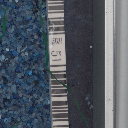

Black-grass
Should be 1.0 = 1.0


In [7]:
#show some images, change the 50 to display other images
image = Image.fromarray(allImg[50])
display(image)
print(catNames[np.argmax(allTarget[50])])
a = max_balanced * 12
b = allTarget.shape[0]
print("Should be 1.0 =", b / a)

In [10]:
# train valid split
stratify = np.argmax(allTarget, axis = 1).reshape((allTarget.shape[0], 1))
trainImg, trainTarget, validImg, validTarget = train_test_split(allImg, allTarget,
                                                                test_size=0.1, random_state=13, stratify=allTarget)

In [30]:
#now, let's train our model
history = model.fit(trainImg, trainTarget, validation_split=0.2, batch_size=64, epochs = 40)

Instructions for updating:
Use tf.cast instead.
Train on 2428 samples, validate on 608 samples
Epoch 1/40
 320/2428 [==>...........................] - ETA: 5:31 - loss: 4.6774 - acc: 0.1313

KeyboardInterrupt: 

{'val_loss': [3.7336974421265694], 'val_acc': [0.0076263107721639654], 'loss': [11.612625143910183], 'acc': [0.22566793893129772]}


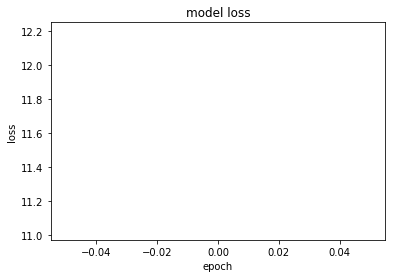

In [17]:
# graph loss over time
print(history.history)
plt.plot(history.history['loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.show()

In [15]:
# evalute model on validation set
scores = model.evaluate(validImg, validTarget, verbose=1)

410/410 [==============================] - 183s 446ms/step


In [34]:
print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))
print(model.metrics_names)

acc: 29.02%
['loss', 'acc']


In [32]:
# Save Model
path_to_models = os.path.join(".", "models")
now = datetime.datetime.now()
date = now.strftime("%Y.%m.%d")
score_truncated = str(scores[1])[1:6]
name = os.path.join(path_to_models, "VGG16_acc" + score_truncated + "_" + date)


model_json = model.to_json()
with open(name + ".json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights(name + ".h5")
print("Saved model to disk")

Saved model to disk


In [46]:
# load json and create model
loaded_model = None
with open(name + ".json", 'r') as json_file:
    loaded_model_json = json_file.read()
    loaded_model = model_from_json(loaded_model_json)
    # load weights into new model
    loaded_model.load_weights(name + ".h5")
    print("Loaded model from disk")

# evaluate loaded model on validation set
loaded_model.compile(optimizer='rmsprop', loss='categorical_crossentropy',metrics=['accuracy'])
score = loaded_model.evaluate(validImg, validTarget, verbose=1)

print("%s: %.2f%%" % (loaded_model.metrics_names[1], score[1]*100))

Loaded model from disk
410/410 [==============================] - 173s 422ms/step
acc: 29.02%
